<a href="https://colab.research.google.com/github/shivtejshete/Computer-Vision/blob/master/X-ray%20Image%20Recognition%20-%20Interstitial%20Lung%20disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import os
import numpy as np
import matplotlib.pyplot as plt


Getting Data from Kaggle using API


In [2]:

!pip install kaggle

In [3]:
# Add this to external cookies allowed list   -  [*.]googleusercontent.com:443
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivtejshete","key":"0ac932149407fa14d4a298ac9296f987"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 41.4MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.8MB/s]


In [6]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip' , 'r')
zip_ref.extractall('files')
zip_ref.close()

In [8]:
path = '/content'
files = os.path.join(path, 'files')
xray_files = os.path.join(files, 'chest_xray')
train = os.path.join(xray_files, 'train')
test = os.path.join(xray_files, 'test')
validation = os.path.join(xray_files, 'val')

In [9]:
os.listdir(path)

['.config', 'files', 'kaggle.json', 'chest-xray-pneumonia.zip', 'sample_data']

In [10]:
TARGET_SIZE = (320,320) 
BATCH_SIZE = 32  #batch size is kept small as there are high number of positive examples in train dataset, incase we can increase it as well to show more negative examples to model


#get training dataset 
train_dataset=keras.preprocessing.image_dataset_from_directory( train, batch_size=BATCH_SIZE, shuffle=True, image_size=TARGET_SIZE , )
#getting class names (0 and then 1)
classes = train_dataset.class_names
#Getting test dataset 
test_dataset=keras.preprocessing.image_dataset_from_directory( test, batch_size=39, shuffle=False, image_size=TARGET_SIZE , )
#Getting validation dataset
validation_dataset=keras.preprocessing.image_dataset_from_directory( validation, batch_size=16, shuffle=False, image_size=TARGET_SIZE ,  )

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)
(320, 320, 3)


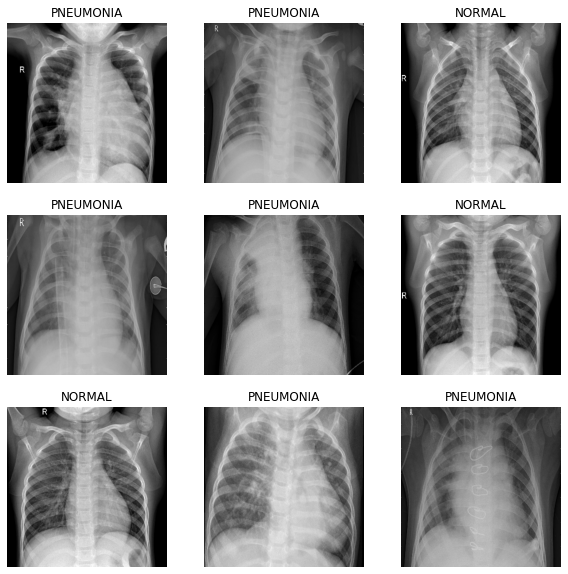

In [11]:
#visualizing some of the training examples 
plt.figure(figsize=(10,10))

for image, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.array(image[i], dtype='int' ))
    plt.title(classes[label[i]])
    plt.axis('off')
    print(np.array(image[i], dtype='int' ).shape)

In [12]:
#Prefetch next elements from training, validation and test set to increase speed of training 
autotune = tf.data.experimental.AUTOTUNE

train_dataset=train_dataset.prefetch(buffer_size=autotune)
test_dataset= test_dataset.prefetch(buffer_size=autotune)
validation_dataset= validation_dataset.prefetch(buffer_size=autotune)


(array([1341.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3875.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

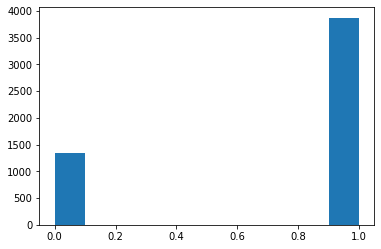

In [13]:
#checking how is the distribution of both the classes in our training dataset, it could be balanced for better generalization or loss function could be changed to incorporate
#imbalance in training examples
a= []
for batch in train_dataset.unbatch():
  a.append(tf.get_static_value( batch[1]))
  
plt.hist(a)


In [14]:
#importing the base model which is a densenet121

input_shape = TARGET_SIZE + (3,)
base_model= keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape )

29089792/29084464 [==============================] - 0s 0us/step


In [15]:
# base_model.summary()
#freeze all the layers of base model
base_model.trainable = False

In [16]:
#prepare a data augmentation layer

data_augment = keras.Sequential(  [keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=1),
                              keras.layers.experimental.preprocessing.RandomContrast(factor = 0.1),
                              keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.05)
                              ])

In [17]:
#prepare data for any preprocessing required by densenet121
densenet_preprocess = tf.keras.applications.densenet.preprocess_input

In [18]:
#Adding the classifier head with average pooling and a dropout layer
pool = keras.layers.GlobalAveragePooling2D()


In [19]:
#trial on sample image from train dataset to check if kayers are functioning the way we expect
for image, label in train_dataset.take(1):
  print("Shape of input image",image[10].shape)
  
  out = base_model(tf.expand_dims(image[10], 0))
  print('base model output',out.shape)

pooling_out = pool(out)
print('pooling layer output', pooling_out.shape)


Shape of input image (320, 320, 3)
base model output (1, 10, 10, 1024)
pooling layer output (1, 1024)


In [20]:
#Classifier on the top 
classifier = keras.Sequential( [keras.layers.Dense(64, activation = 'relu'),
                                keras.layers.Dropout(0.2),
                                keras.layers.Dense(1)], name='top_classifier' )


# classifier = keras.layers.Dense(1)

In [48]:
#creating a model with grouping all layers together 

input= tf.keras.Input(shape= input_shape)
x= data_augment(input)
x= densenet_preprocess(x)
x= base_model(x, training= False )
x= pool(x)
x= keras.layers.Dropout(0.1)(x)
output= classifier(x)

model = keras.Model(inputs = input, outputs = output)


In [42]:
#final model summary
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 320, 320, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_10 (Tens [(None, 320, 320, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_5 (Tenso [(None, 320, 320, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_11 (Tens [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)            

In [43]:
len(model.trainable_variables)

4

In [49]:
#compile the model with mentioning the optimizer, metrics and loss function
lr = 0.001
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       # keras.metrics.BinaryAccuracy(name='accuracy'),
# #       keras.metrics.Precision(name='precision'),
# #       keras.metrics.Recall(name='recall'),
#       # keras.metrics.AUC(name='auc'),
#   ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr) , 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= ['accuracy']) 

In [50]:
#setting the callback function for more control on training of the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True )

In [51]:
#checking the initial accuracy of the model on test set 
base_test_loss,base_test_acc =  model.evaluate(test_dataset)
print(base_test_loss)
print(base_test_acc)

#checking model performance on validation dataset
base_val_loss,base_val_acc =  model.evaluate(validation_dataset)
print(base_val_loss)
print(base_val_acc)

16/16 [==============================] - 4s 258ms/step - loss: 0.3086 - accuracy: 0.8942
0.30859825015068054
0.8942307829856873
1/1 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.8750
0.25840502977371216
0.875


In [52]:
initial_epoch = 8

history = model.fit( train_dataset, epochs= initial_epoch, validation_data=test_dataset, callbacks=[early_stopping],  )

Epoch 1/8
163/163 [==============================] - 49s 298ms/step - loss: 0.1795 - accuracy: 0.9285 - val_loss: 0.3253 - val_accuracy: 0.8782
Epoch 2/8
163/163 [==============================] - 48s 295ms/step - loss: 0.1702 - accuracy: 0.9308 - val_loss: 0.2911 - val_accuracy: 0.9006
Epoch 3/8
163/163 [==============================] - 49s 298ms/step - loss: 0.1631 - accuracy: 0.9319 - val_loss: 0.2606 - val_accuracy: 0.9167
Epoch 4/8
163/163 [==============================] - 48s 297ms/step - loss: 0.1564 - accuracy: 0.9369 - val_loss: 0.2313 - val_accuracy: 0.9215
Epoch 5/8
163/163 [==============================] - 48s 293ms/step - loss: 0.1631 - accuracy: 0.9350 - val_loss: 0.3136 - val_accuracy: 0.8942
Epoch 6/8
163/163 [==============================] - 48s 294ms/step - loss: 0.1469 - accuracy: 0.9411 - val_loss: 0.2817 - val_accuracy: 0.9119
Epoch 7/8
163/163 [==============================] - 48s 292ms/step - loss: 0.1551 - accuracy: 0.9356 - val_loss: 0.2311 - val_accuracy:

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

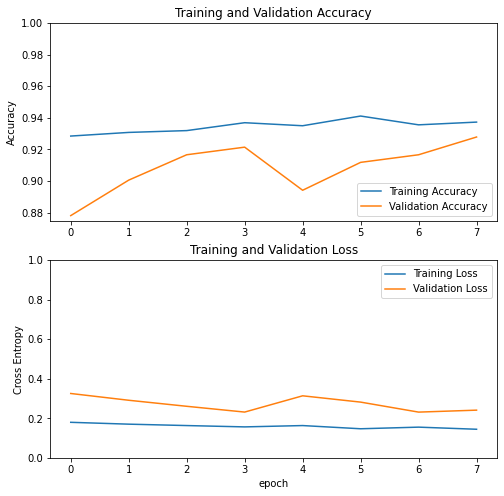

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
first_fit_val_loss, first_fit_val_acc =  model.evaluate(validation_dataset)
print(first_fit_val_loss)
print(first_fit_val_acc)

1/1 [==============================] - 0s 3ms/step - loss: 0.1057 - accuracy: 0.9375
0.10571372509002686
0.9375


In [77]:
#predicting on validation dataset
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()

prediction = model.predict_on_batch(image_batch).flatten()  #yields logit values and need to be treated with sigmoid afterwards for getting probabilities 

prediction_prob = tf.sigmoid(prediction)
prediction_prob

prediction_class = tf.where(prediction_prob>0.5, 1, 0)
from sklearn.metrics import confusion_matrix
confusion_matrix(label_batch, prediction_class)


array([[8, 0],
       [0, 8]])

In [76]:
#prediction on test dataset
image_batch_test, label_batch_test = test_dataset.as_numpy_iterator().next()

prediction_test = model.predict_on_batch(image_batch_test).flatten()  #yields logit values and need to be treated with sigmoid afterwards for getting probabilities 

prediction_prob_test = tf.sigmoid(prediction_test)

prediction_class_test = tf.where(prediction_prob_test>0.5, 1, 0)
confusion_matrix(label_batch_test, prediction_class_test)

array([[38,  1],
       [ 0,  0]])

In [52]:
#Approach for resampling with balanced dataset 
#Getting balanced dataset with distribution probability of 50% 50% for both the classes of normal and positive
def class_func(features, label):
  return label


resampler = tf.data.experimental.rejection_resample( class_func, target_dist=[0.5, 0.5], seed=1, )
#resampled dataset returns a label, feauture and label pair. Drop first label with is a duplication 
resample_ds = train_dataset.unbatch().apply(resampler).batch(32)

#use lambda to drop first item of element which is a repeated label
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

#Checking the balanced dataset labels once done 
for features, labels in balanced_ds.take(-1):
  print(labels.numpy())
  break

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[ 43.65     43.65     43.65   ]
  [ 43.65     43.65     43.65   ]
  [ 43.       43.       43.     ]
  ...
  [170.95468 170.95468 170.95468]
  [120.34065 120.34065 120.34065]
  [130.97482 130.97482 130.97482]]

 [[ 44.025    44.025    44.025  ]
  [ 44.025    44.025    44.025  ]
  [ 44.       44.       44.     ]
  ...
  [187.91719 187.91719 187.91719]
  [176.15288 176.15288 176.15288]
  [138.50047 138.50047 138.50047]]

 [[ 46.       46.       46.     ]
  [ 46.       46.   

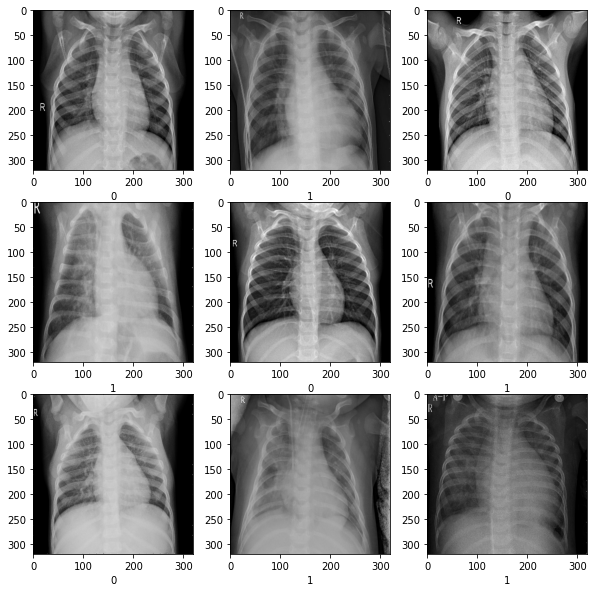

In [89]:
#visualizing some of images from balanced dataset 
for image, label in balanced_ds.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax=plt.subplot( 3,3,i+1)
    # print(np.asarray(image[i]))
    plt.imshow(np.asarray(image[i], dtype='int'))
    plt.xlabel(tf.get_static_value(label[i]) )

    
    